# Code Generating Discrete Legendre Orthogonal Polynomials and the Legendre Delay Network Basis

Andreas Stöckel, December 2020

**License:**  
The code in this Jupyter Notebook is licensed under the Creative Commons Zero license. To the extent possible under law, Andreas Stöckel has waived all copyright and related or neighboring rights to this code. You should have received a complete copy of the license along with this code. If not, please visit https://creativecommons.org/publicdomain/zero/1.0/legalcode-plain. This work is published from: Canada.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from dlop_ldn_function_bases import * # see "function_bases.py" for the actual code

## Plotting Code

In [3]:
# Helper function used to compare the individual bases
def plot_basis(B, varname='T', bottom_labels=True):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    plt.rcParams['figure.dpi'] = 200

    height = 2.0 if bottom_labels else 1.6
    fig, axs = plt.subplots(1, 3, figsize=(4.5, height), constrained_layout=True)
    axs[0].imshow(B @ B.T, interpolation='nearest',
                  extent=(0.5, B.shape[0] + 0.5, B.shape[0] + 0.5, 0.5))
    axs[0].set_xticks(np.linspace(1, B.shape[0], 5, dtype=np.int))
    axs[0].set_yticks(np.linspace(1, B.shape[0], 5, dtype=np.int))
    axs[0].set_title("$\\mathbf{{{}}} \\mathbf{{{}}}^T$".format(varname, varname))
    axs[0].set_ylabel("Row $i$")
    if bottom_labels:
        axs[0].set_xlabel("Column $j$")

    axs[1].imshow(B, interpolation='nearest',
                  extent=(0.5, B.shape[1] + 0.5, B.shape[0] + 0.5, 0.5))
    axs[1].set_xticks(np.linspace(1, B.shape[1], 5, dtype=np.int))
    axs[1].set_yticks(np.linspace(1, B.shape[0], 5, dtype=np.int))
    axs[1].set_title("$\\mathbf{{{}}}$".format(varname))
    #axs[1].set_yticklabels([])
    axs[1].set_ylabel("Row $i$")
    axs[1].set_aspect(B.shape[1] / B.shape[0])
    if bottom_labels:
        axs[1].set_xlabel("Column $j$")

    axs[2].plot(np.arange(1, B.shape[1] + 1), B[:6].T);
    axs[2].set_xticks(np.linspace(1, B.shape[1], 3, dtype=np.int))
    axs[2].set_title("First basis vectors $(\\mathbf{{{}}})_i$".format(varname))
    axs[2].set_xlim(1, B.shape[1] + 1)
    if bottom_labels:
        axs[2].set_xlabel("Column $j$")
    xlim, ylim = axs[2].get_xlim(), axs[2].get_ylim()
    w, h = xlim[1] - xlim[0], ylim[1] - ylim[0]
    axs[2].set_aspect(w / h)

    for ax in axs.flat:
        for spine in ["top", "left", "bottom", "right"]:
            ax.spines[spine].set_position(('outward', 5.0))

    return fig, axs

## Fourier and Cosine Basis

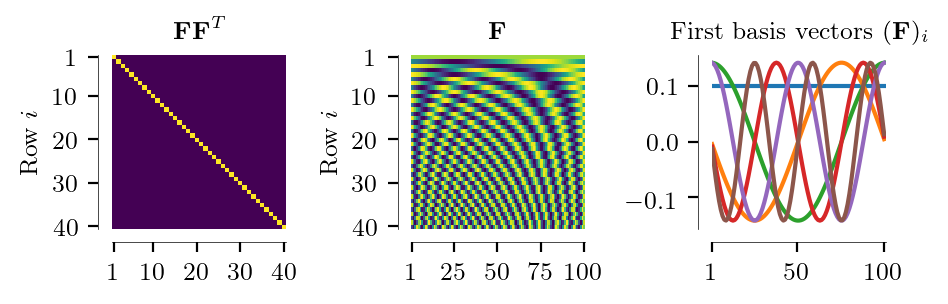

In [4]:
F = mk_fourier_basis(40, 100)
fig_F, _ = plot_basis(F, 'F', bottom_labels=False)

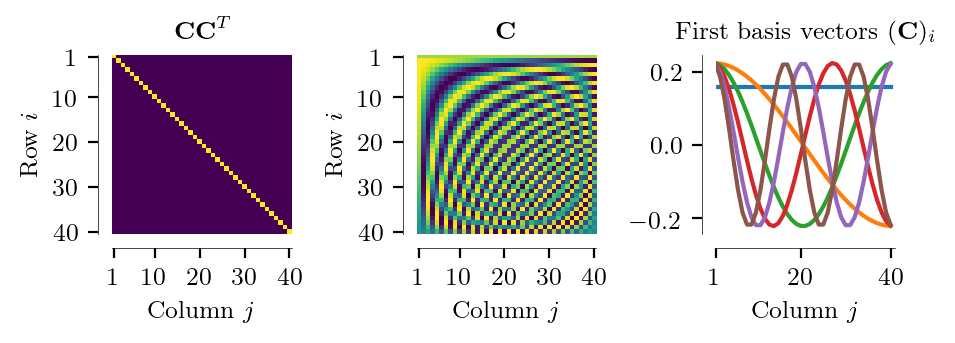

In [5]:
C = mk_cosine_basis(40, 40)
fig_C, axs = plot_basis(C, 'C')

## LDN Basis

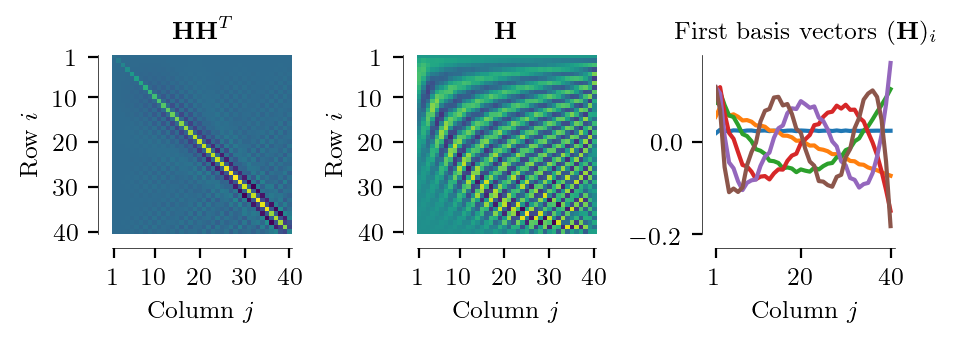

In [6]:
H = mk_ldn_basis(40, 40)
fig_H, axs = plot_basis(H, 'H')

## Discretised Legendre Basis

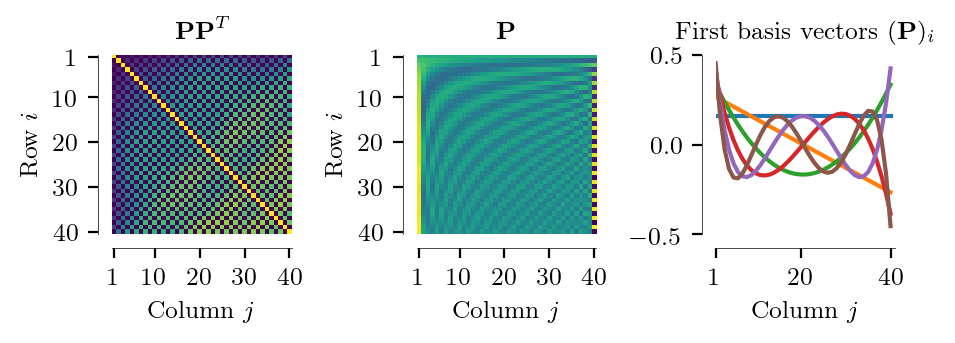

In [7]:
P = mk_leg_basis(40, 40)
fig_P, axs = plot_basis(P, 'P')

## DLOP Basis

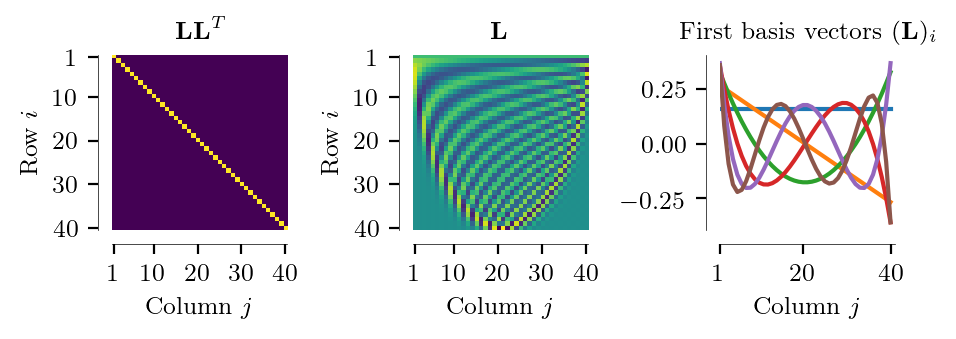

In [8]:
L = mk_dlop_basis(40, 40)
fig_L, axs = plot_basis(L, 'L')

## Low-pass Filtered DLOP Basis

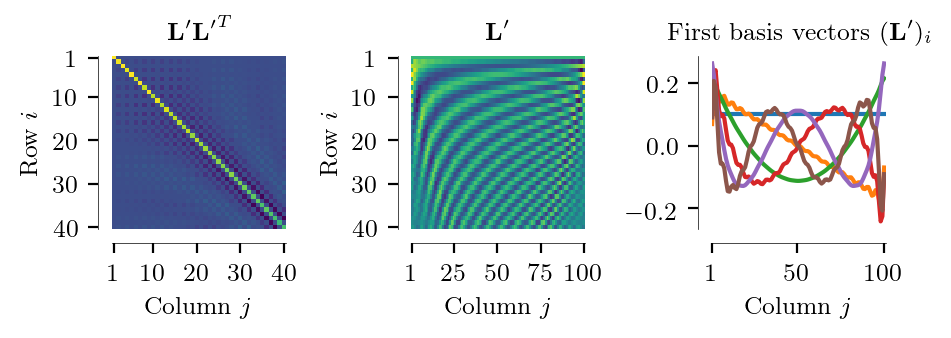

In [9]:
Lp = lowpass_filter_basis(mk_dlop_basis(40, 100))
fig_Lp, axs = plot_basis(Lp, 'L\'')